In [1]:
import hydra
import re
import pyrootutils
import os
import torch

from omegaconf import OmegaConf
import json
from typing import Optional
import transformers
from PIL import Image
from torchvision.transforms.functional import InterpolationMode

# pyrootutils.setup_root(__file__, indicator=".project-root", pythonpath=True)

BOI_TOKEN = '<img>'
EOI_TOKEN = '</img>'
IMG_TOKEN = '<img_{:05d}>'

sep = "\n"
user_token = "USER"
assistant_token = "ASSISTANT"

IMG_FLAG = '<image>'
NUM_IMG_TOKNES = 32
NUM_IMG_CODES = 8192
image_id_shift = 32000

def generate(tokenizer, input_tokens, generation_config, model):
    """Only for batch_size=1"""

    input_ids = tokenizer(input_tokens, add_special_tokens=False, return_tensors='pt').input_ids
    input_ids = input_ids.to(model.device)

    generate_ids = model.generate(
        input_ids=input_ids,
        generation_config=generation_config
    )
    generate_ids = generate_ids[0][input_ids.shape[1]:]
    
    return generate_ids

def replace_img_tags(input_text):
    img_pattern = re.compile(r'<img>(.*?)</img>', re.IGNORECASE)
    img_matches = img_pattern.findall(input_text)
    
    for i, match in enumerate(img_matches):
        replacement = f'<IMAGE>'
        input_text = input_text.replace(f'<img>{match}</img>', replacement)
    
    return input_text
    
# def decode_image_text(generate_ids, tokenizer, save_path=None):

#     boi_list = torch.where(generate_ids == tokenizer(BOI_TOKEN, add_special_tokens=False).input_ids[0])[0]
#     eoi_list = torch.where(generate_ids == tokenizer(EOI_TOKEN, add_special_tokens=False).input_ids[0])[0]

#     if len(boi_list) == 0 and len(eoi_list) == 0:
#         text_ids = generate_ids
#         texts = tokenizer.decode(text_ids, skip_special_tokens=True)
#         print(texts)

#     else:
#         # for boi_index, eoi_index in zip(boi_list, eoi_list):

#         boi_index = boi_list[0]
#         eoi_index = eoi_list[0]

#         text_ids = generate_ids[:boi_index]
#         if len(text_ids) != 0:
#             texts = tokenizer.decode(text_ids, skip_special_tokens=True)
#             print(texts)
            
#         image_ids = (generate_ids[boi_index+1:eoi_index] - image_id_shift).reshape(1,-1)

#         images = tokenizer.decode_image(image_ids)

#         images[0].save(save_path)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append("/lid/home/saydalie/multimodal_cot/SEED/")

from models.seed_llama_tokenizer import SeedLlamaTokenizer
from models.transforms import get_transform
from models.model_tools import get_pretrained_llama_causal_model

In [3]:
encoder_path="/lid/home/saydalie/multimodal_cot/SEED/checkpoints/seed-tokenizer-2/seed_quantizer.pt"

tokenizer = SeedLlamaTokenizer.from_pretrained(
    pretrained_model_name_or_path="AILab-CVC/seed-tokenizer-2",
    fp16=True,
    load_diffusion=True,
    encoder_url=encoder_path,
    padding_side = 'left',
    diffusion_path="stabilityai/stable-diffusion-2-1-unclip"
)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LlamaTokenizer'. 
The class this function is called from is 'SeedLlamaTokenizer'.
You are using the default legacy behaviour of the <class 'models.seed_llama_tokenizer.SeedLlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message
/home/saydalie/.local/lib/python3.10/site-packages/timm/models/hub.py:4: FutureWarning: Importing from timm.models.hub is deprecated, please import via timm.models
  warn

missing keys:  511 unexpected keys: 146


Loading pipeline components...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.44s/it]


In [4]:
device = "cuda"
# model_name_or_path="/lid/home/saydalie/multimodal_cot/models/SEED_trained/seed-llama-8b-GRPO-resq/final_merged"
model_name_or_path="/lid/home/saydalie/multimodal_cot/SEED/checkpoints/seed-llama-8b-sft-comm"
# model_name_or_path="/lid/home/saydalie/multimodal_cot/SEED/checkpoints/seed-llama-8b-sft"

model = get_pretrained_llama_causal_model(
    pretrained_model_name_or_path=model_name_or_path,
    torch_dtype="bf16",
    low_cpu_mem_usage=True
).eval().to(device)

/home/saydalie/.local/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:607: UserWarning: `pad_token_id` should be positive but got -1. This will cause errors when batch generating, if there is padding. Please set `pad_token_id` explicitly as `model.generation_config.pad_token_id=PAD_TOKEN_ID` to avoid errors in generation
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:17<00:00,  5.70s/it]


### Generate

In [5]:
from transformers.generation.configuration_utils import GenerationConfig

generation_config = GenerationConfig(
    temperature=0.9,
    num_beams=1,
    max_new_tokens=512,
    top_p=0.9,
    do_sample=True
)

In [6]:
prompt="""{bos}{user_token}: I now describe a scene and ask a question about it. First, think about the reasoning process using an interleaved combination of images and text. You should generate an image when necessary to support reasoning, then describe insights from the image. Finally, provide with the answer. The final answer is either one of {candidate_answers}. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process with images and text here </think> <answer> the final answer here </answer>.
{question}
{assistant_token}:"""

scene = "A white hostel with a large tree to its left and a gravel road in front of the wooden entrance."
question = "Is the white thing behind the tree?"

input_tokens = prompt.format(
    bos=tokenizer.bos_token,
    user_token=user_token,
    candidate_answers=["Yes", "No"],
    assistant_token=assistant_token,
    question=f"{scene} {question}"
)

print(input_tokens)

<s>USER: I now describe a scene and ask a question about it. First, think about the reasoning process using an interleaved combination of images and text. You should generate an image when necessary to support reasoning, then describe insights from the image. Finally, provide with the answer. The final answer is either one of ['Yes', 'No']. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process with images and text here </think> <answer> the final answer here </answer>.
A white hostel with a large tree to its left and a gravel road in front of the wooden entrance. Is the white thing behind the tree?
ASSISTANT:


In [28]:
generate_ids = generate(tokenizer, input_tokens, generation_config, model)
generate_ids.shape

torch.Size([155])

### Decode

In [29]:
# decode text
output_text = tokenizer.decode(generate_ids, skip_special_tokens=False)
output_text = replace_img_tags(output_text)
output_text

'<think> It is difficult to determine the exact location of the white thing, but we can see that it is behind the large tree. This means that the white thing must be on the other side of the tree. However, the white thing is also not visible on the other side of the tree. Therefore, we can only assume that the white thing is on this side of the tree. The white thing is probably an object placed on top of a building or in a yard. Therefore, we can answer our question: "No."</think><answer> No.</answer> <IMAGE> </s><s>'

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 22.70it/s]


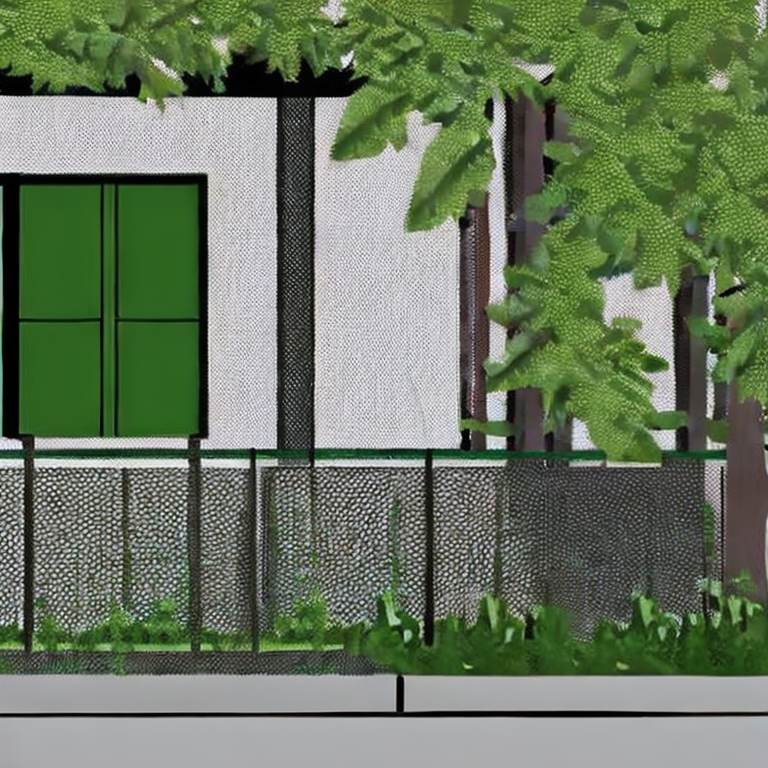

In [30]:
# decode images
boi_list = torch.where(generate_ids == tokenizer(BOI_TOKEN, add_special_tokens=False).input_ids[0])[0]
eoi_list = torch.where(generate_ids == tokenizer(EOI_TOKEN, add_special_tokens=False).input_ids[0])[0]

for boi_index, eoi_index in zip(boi_list, eoi_list):
    image_ids = (generate_ids[boi_index+1:eoi_index] - image_id_shift).reshape(1,-1)
    image = tokenizer.decode_image(image_ids)[0]
    image.show()